# Measure and improve


All these weeks we were exploring different ways to build a search engine: based on vectors, graphs, trees. We were adding new features such as spell-checking and suggest. This all might seem good, however, we have no ways to tell if our changes were indeed enhancements. How do we know that search engine's quality haven't deteriorated because of our changes? How do we know if cosine scoring is better than okapi scoring? How can we check if applying language models instead of vector-space models is beneficial? 

All we need is a way to ***evaluate*** our search engine. We will consider some of the popular evaluation techniques:

1. Mean Average Precision
2. Normalized Discounted Cumulative Gain (NDCG)
3. 11-Point Interpolated Average

We will apply them in the context of ranking with language models and will compare two ways of smoothing: additive and Jelinek-Mercer smoothing.  

It's best to go through the [book](https://nlp.stanford.edu/IR-book/pdf/irbookonlinereading.pdf) *chapter 8*, concretely, *8.4* to understand the key concepts of this lab. Here we will only present some excerpts from it.


## Data

There is a number of ways to evaluate a search engine, however, all of them require so called relevance judgements - human assigned scores of relevance between query-doc_id pairs. We will use Cranfield relevance judgements collection, download it from [here](https://drive.google.com/drive/folders/1u6dSUqdrXsckSHmVHNNE27eDiajMWLl2?usp=sharing). 

This was the pioneering test collection in allowing precise quantitative measures of information retrieval effectiveness, but is nowadays too small for anything but the most elementary pilot experiments (which is exactly what we are doing here). Collected in the United Kingdom starting in the late 1950s, it contains 1400 abstracts of aerodynamics journal articles, a set of 225 queries, and exhaustive relevance judgments of all (query, document) pairs.

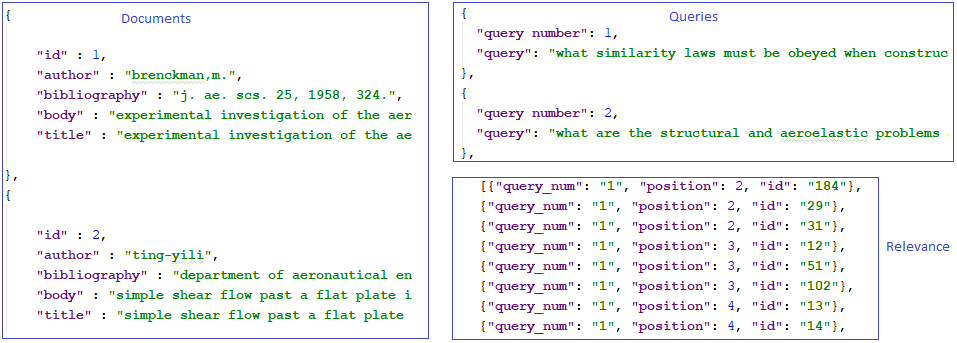


It comes in a json format, the detailed description is available in the readme file.


In [1]:
import json, os
import pandas as pd

# TODO: read the cranfield data
# relevance should be a dictionary, query_id:[(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]

def read_cranfield(path):
    '''Read documents and metadata from folder : path'''
    
    assert os.path.isdir(path), 'data folder path does not exist'
    
    documents = None
    with open(path+'cranfield_data.json') as f:
        documents = json.load(f)
    
    queries = None
    with open(path+'cran.qry.json') as f:
        queries = json.load(f)
    
    relevance = {}
    with open(path+'cranqrel.json') as f:
        cranqrel = json.load(f)
        for name, group in pd.DataFrame(cranqrel).groupby('query_num'):
            relevance[name] = [( x["id"],x["position"]) for _ , x in group.iterrows()]
    
    return documents, queries, relevance

cran_orig_path = 'cranfield_data/'
documents, queries, relevance = read_cranfield(cran_orig_path)

### Test 

In [2]:
assert len(documents) == 1400 
assert len(relevance) == 225

## 1. Mean Average Precision

The most standard metric among the TREC community is *Mean Average Precision* *(MAP)*, which provides a single-figure measure of quality across recall levels. Among evaluation measures, MAP has been shown to have especially good discrimination and stability. For a single information need, Average Precision is the average of the precision value obtained for the set of top k documents existing
after each relevant document is retrieved, and this value is then averaged over information needs (queries). That is, if the set of relevant documents for an information need q<sub>j</sub> ∈ Q is {d<sub>1</sub>, . . . d<sub>m<sub>j</sub></sub>} and R<sub>jk</sub> is the set of ranked retrieval results from the top result until you get to document d<sub>k</sub>, then

![](https://i.imgur.com/EGQMHVq.png)

Implement this metric in the `mean_avg_precision` function.


In [3]:
import numpy as np
def mean_avg_precision1(ranking_results, query_actual_rank):
    """
    Calculates MAP score for search results.  
    
    Args:
        ranking_results : (list) list of lists of ranked results for each query [[doc_id1, doc_id2,...], ...]
        query_actual_rank : (dict), ground truth for each query {query_id:[(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]} 
    
    Returns:
        Mean average precision
    """
    result = []
    for real, retrived in zip(query_actual_rank.items(),ranking_results) :
        curr_res = []
        real = dict(real[1])
        print("real scores : ",real)
        print("retrived Scores : ",retrived)
        for doc_id , real_score in real.items(): 
            retrived_relevance = retrived.index(int(doc_id)) + 1
            print('test score : ',retrived_relevance, ', real Score:',real_score, ' -->',f'({real_score}/{retrived_relevance})')
            curr_res.append(real_score/retrived_relevance)
        print(curr_res)
        print('divide by : ',len(real))
        result.append(np.mean(curr_res))
    print("res : ",result)
    #print("overall divide by : ", len(ranking_results))
    return np.mean(result)


In [4]:
import numpy as np
def mean_avg_precision(ranking_results, query_actual_rank):
    """
    Calculates MAP score for search results.  
    
    Args:
        ranking_results : (list) list of lists of ranked results for each query [[doc_id1, doc_id2,...], ...]
        query_actual_rank : (dict), ground truth for each query {query_id:[(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]} 
    
    Returns:
        Mean average precision
    """
    result = []
    for (_,real), retrived in zip(query_actual_rank.items(),ranking_results) :
        real = list(dict(real).keys())
        
        r = np.isin(retrived,real)*1
        z = r.nonzero()[0]
        
        if not z.size: result.append(0.0)
        else : result.append(np.mean(np.arange(1,len(z)+1)/(z+1)))
    
    return np.mean(result)

### 1.1 Test

In [5]:
import numpy as np

test_relevance = {1: [(9, 1), (1, 2), (8, 3)], 2: [(5, 1), (9, 2), (6, 3)], 
                  3: [(9, 1), (4, 2), (6, 3)], 4: [(10, 1), (4, 2), (7, 3)], 
                  5: [(4, 1), (2, 2), (8, 3)], 6: [(2, 1), (9, 2), (4, 3)], 
                  7: [(1, 1), (2, 2), (3, 3)], 8: [(3, 1), (2, 2), (6, 3)], 
                  9: [(1, 1), (4, 2), (3, 3)], 10: [(10, 1), (7, 2), (8, 3)]}
test_results = [[4, 5, 3, 6, 1, 2, 8, 9, 10, 7], [7, 5, 6, 3, 1, 8, 9, 4, 2, 10], 
                [8, 3, 4, 5, 9, 6, 1, 10, 2, 7], [4, 5, 7, 3, 6, 10, 1, 9, 2, 8], 
                [4, 8, 3, 5, 6, 7, 2, 1, 10, 9], [9, 7, 6, 5, 2, 4, 10, 1, 3, 8], 
                [3, 1, 5, 2, 10, 6, 7, 9, 8, 4], [9, 2, 4, 10, 8, 3, 7, 6, 1, 5], 
                [3, 4, 6, 1, 5, 10, 7, 2, 8, 9], [8, 10, 4, 1, 3, 7, 5, 6, 9, 2]]


map_test = mean_avg_precision(test_results, test_relevance)
print("map_test", map_test)
assert np.isclose(map_test, 0.646, atol=1e-03)
assert mean_avg_precision(test_results[:5], test_relevance) > mean_avg_precision(test_results[5:10], test_relevance)

map_test 0.6464285714285714


## 2. Normalized Discounted Cumulative Gain (Bonus task)

There is also so called NDCG metric, which is designed for situations of non-binary notions of relevance. It is evaluated over some number *k* of top search results (in our case we will evaluate over the whole dataset, since it is small). 

For a set of queries Q, let *R(j,d)* be the relevance score assessors gave to document *d* for query *j*. Then,

![](https://i.imgur.com/LLogCYa.png)

where Z<sub>kj</sub> is a normalization factor calculated to make it so that a perfect ranking’s NDCG at *k* for query *j* is 1. In other words, we divide calculated DCG score by ideal DCG score. 

Implement this metric in `NDCG` function.

In [6]:
def DCG(relavence_scores):
    """
    Score is discounted cumulative gain (dcg)
    implementation from : https://en.wikipedia.org/wiki/Discounted_cumulative_gain#Discounted_Cumulative_Gain
    Relevance is positive real values.

    Args:
        relavence_scores : (numpy or list) Relevance scores (list or numpy) in rank order
        (first element is the first item)
        formulation : (string) If default then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                    else weights are [1.0, 0.6309, 0.5, 0.4307, ...]
        
    Returns:
        Discounted cumulative gain
    """
    assert relavence_scores.size > 0 , 'Error with input!'
    
    if relavence_scores.size:
        return np.sum(np.subtract(np.power(2, relavence_scores), 1) / np.log2(np.arange(2, relavence_scores.size + 2)))
    return 0.

def NDCG(retrieved_relevance, actual_relevance):
    '''
    Score is discounted cumulative gain (dcg)
    implementation from : https://en.wikipedia.org/wiki/Discounted_cumulative_gain#Discounted_Cumulative_Gain
    Relevance is positive real values.

    Args:
        retrieved_relevance : (numpy or list) retrieved Relevance scores (list or numpy) in rank order
        (first element is the first item)
        actual_relevance : (dict) Actual relevence scores for each query {query_id:[(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]} 
        
    Returns:
        Normalized Discounted cumulative gain
    '''
    
    res = []
    for pred_list, (_, actual) in zip(retrieved_relevance,actual_relevance.items()) :
        curr_res = []
        actual = dict(actual)
        
        mask = np.isin(pred_list,list(actual.keys()))
        retrieved_r = np.zeros(len(pred_list))
        retrieved_r[mask] = [5.0 - actual.get(i) for i in np.array(pred_list)[mask]]
        
        dcg = DCG(retrieved_r)
        max_dcg = DCG(np.sort(retrieved_r)[::-1])

        if not max_dcg : res.append(0.0)
        else : res.append(dcg/max_dcg)
        
    return np.mean(res)

### 2.1 Test

In [7]:
ndcg_test = NDCG(test_results, test_relevance)
print("ndcg_test", ndcg_test)
assert np.isclose(ndcg_test, 0.640, atol=1e-03)
assert NDCG(test_results[:5], test_relevance) < NDCG(test_results[5:10], test_relevance)

ndcg_test 0.6409675295633275


In [8]:
import unittest

class TestNotebook(unittest.TestCase):
    
    retrieved_1 = [[4, 5, 3, 6, 11, 2, 18, 19, 10, 7], [7, 15, 16, 3, 1, 8, 19, 4, 2, 10]]
    actual_1 = {1: [(9, 1), (1, 2), (8, 3)], 2: [(5, 1), (9, 2), (6, 3)]}
    retrieved_2 = [[4, 2, 8, 5, 6, 7, 3, 1, 10, 9], [2, 9, 4, 5, 7, 6, 10, 1, 3, 8]]
    actual_2 = {5: [(4, 1), (2, 2), (8, 3)], 6: [(2, 1), (9, 2), (4, 3)]}
    retrieved_3 = [[1, 7, 2, 6, 9, 3, 8, 10, 4, 5], [10, 1, 5, 7, 2, 8, 3, 4, 6, 9]]
    actual_3 = {1: [(1, 1), (2, 2), (3, 3),(4, 4), (5, 5)], 2: [(1, 1), (2, 2), (3, 3)]}
    
    def test_data_read(self):
        documents, queries, relevance = read_cranfield('cranfield_data/')
        with self.subTest():
            self.assertEqual(len(documents),1400)
        
        with self.subTest():
            self.assertEqual(len(relevance),225)
            
    def test_mean_avg_precision(self):
        with self.subTest():
            self.assertAlmostEqual(mean_avg_precision(self.__class__.retrieved_1,self.__class__.actual_1),0.000,places=4)
        
        with self.subTest():
            self.assertAlmostEqual(mean_avg_precision(self.__class__.retrieved_2,self.__class__.actual_2),1.000,places=3)
            
        with self.subTest():
            self.assertAlmostEqual(mean_avg_precision(self.__class__.retrieved_3,self.__class__.actual_3),0.53,places=2)
    
    def test_discounted_cumulative_gain(self):
        scores = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        with self.subTest():
            self.assertNotEqual(DCG(scores),9.60511773918)
        
        with self.subTest():
            with self.assertRaises(AssertionError):
                DCG(np.array([]))
    
    def test_normalized_DCG(self):
        with self.subTest():
            self.assertAlmostEqual(NDCG(self.__class__.retrieved_1,self.__class__.actual_1),0.000,places=4)
        
        with self.subTest():
            self.assertAlmostEqual(NDCG(self.__class__.retrieved_2,self.__class__.actual_2),1.000,places=3)
            
        with self.subTest():
            self.assertAlmostEqual(NDCG(self.__class__.retrieved_3,self.__class__.actual_3),0.7802,places=2)

_ = unittest.main(argv=[''], verbosity=2, exit=False)

test_data_read (__main__.TestNotebook) ... ok
test_discounted_cumulative_gain (__main__.TestNotebook) ... ok
test_mean_avg_precision (__main__.TestNotebook) ... ok
test_normalized_DCG (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.436s

OK


## 3. 11-Point Interpolated Average (Bonus task)

In a ranked retrieval context, appropriate sets of retrieved documents are naturally given by the top k retrieved documents. For each such set, precision and recall values can be plotted to give a precision-recall curve, such as this one (blue line):

![](https://i.imgur.com/QnvDLAJ.png)

Precision-recall curves have a distinctive saw-tooth shape: if the *(k + 1)<sup>th</sup>* document retrieved is nonrelevant then recall is the same as for the top k documents, but precision has dropped. If it is relevant, then both precision and recall increase, and the curve jags up and to the right.

It is often useful to remove these jiggles and the standard way to do this is with an *interpolated precision*: the interpolated precision *p<sub>interp</sub>* at a certain recall level *r* is defined as the highest precision found for any recall level *r′* ≥ *r*:

![](https://i.imgur.com/GMl2rQw.png)

The justification is that almost anyone would be prepared to look at a few more documents if it would increase the percentage of the viewed set that were relevant (that is, if the precision of the larger set is higher). Interpolated precision is shown by a red line in the figure above.

Examining this information for a single query may be useful, but usually we are more interested in a composite metrics, which will score over all test queries. The traditional way of doing this is the *11-point interpolated average*. For each information need, the interpolated precision is measured at the 11 recall levels of 0.0, 0.1, 0.2, . . . , 1.0. Then we average interpolated precision over all queries in the test collection and plot, like here:

![](https://i.imgur.com/6wDmtp2.png)


Plotting a number of such graphs for different versions of search engine on the same plot helps to compare their performance.

You need to incorporate this logic into `eleven_points_interpolated_avg` function. Break it down to subfuctions as it seems necessary to you.

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def eleven_points_interpolated_avg(ranking_results, query_actual_rank, plot=True):
    '''
    11-Point Interpolated Average
    
    Score is discounted cumulative gain (dcg)
    implementation from : https://en.wikipedia.org/wiki/Discounted_cumulative_gain#Discounted_Cumulative_Gain
    Relevance is positive real values.

    Args:
        retrieved_relevance : (numpy or list) retrieved Relevance scores (list or numpy) in rank order
        (first element is the first item)
        actual_relevance : (dict) Actual relevence scores for each query {query_id:[(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]}
        plot : (bloolean) flag for plotting the obtained 11-Point Interpolated Average gragh 
        
    Returns:
        interpolated avgerage, numpy array of 11 values 
    '''
    result = []
    for (_,real), retrived in zip(query_actual_rank.items(),ranking_results) :
        real = list(dict(real).keys())
        
        r = np.isin(retrived,real)*1
        z = r.nonzero()[0]
        
        if not z.size: result.append(0.0)
        else : 
            recall = np.cumsum(r)/z.size
            precision = np.zeros(len(recall))
            precision[z] = np.arange(1,len(z)+1)/(z+1)
            
        curr_p_interpol = []
        for r in np.arange(0,1.1,0.1):
            mask = np.where(recall >= r)[0]
            if mask.size == 0: curr_p_interpol.append(0.0)
            else : curr_p_interpol.append(precision[mask].max())
        
        result.append(curr_p_interpol)
    # return: interpolated_avg, list of 11 values 
    interpolated_avg = np.mean(result,axis=0)
    if plot:
        plt.plot(np.arange(0,1.1,0.1),interpolated_avg )
        plt.xlabel('recall')
        plt.ylabel('precision')
        plt.title('11-Point Interpolated Average')
        plt.show()
    
    return interpolated_avg

### 3.1  Test

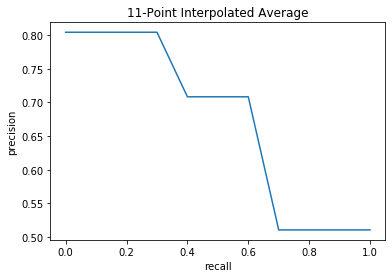

In [10]:
eleven_test = eleven_points_interpolated_avg(test_results, test_relevance, plot=True)
assert all(eleven_test[k] >= eleven_test[k+1] for k in range(len(eleven_test)-1))

## 4. Evaluation

Now we want to apply these metrics and compare two ways of smoothing in ranking with language models. Since we only have relevance scores for Cranfield data, we will run search and do evaluaions based on it.

### LM ranking

In [19]:
# TODO: copy here your lm_rank_documents function from the last lab

def lm_rank_documents(query, tdm, terms_list, smoothing='additive', param=0.001):
    """
    :param query: dict, term:count            
    :param tdm: term-document matrix
    :param terms_list: vocabulary list
    :param smoothing: which smoothing to apply, either 'additive' or 'jelinek-mercer'
    :param param: alpha for additive / lambda for jelinek-mercer
    :return: list of scores, list of doc_ids sorted by their scores 
    """
    n_docs = tdm.shape[0]
    doc_lengths = tdm.sum(axis=1)
    len_collection = np.sum(doc_lengths)
    scores = np.zeros(n_docs)
    for term in query.keys():
        # check if term exists
        if term in terms_list:
            # get term's id
            term_id = terms_list.index(term)
        else:
            continue
        query_tf = query[term]
        # calculate collection frequency of a term
        collection_tf = np.sum(tdm[:, term_id])
        for doc_id in range(n_docs):
            doc_tf = tdm[doc_id, term_id]
            # apply smoothing of any
            if smoothing == 'additive':
                doc_score_factor = (doc_tf + param) / (doc_lengths[doc_id] + param*len(terms_list))
            elif smoothing == 'jelinek':
                doc_score_factor = param*doc_tf/doc_lengths[doc_id] + (1-param)*collection_tf/len_collection
            else:
                doc_score_factor = doc_tf/doc_lengths[doc_id]
            doc_score_factor = doc_score_factor**query_tf

            if doc_id not in scores:
                scores[doc_id] = 1
            # accumulate scores
            scores[doc_id] *= doc_score_factor
    # sort doc_ids by scores
    sorted_doc_ids = np.argsort(-scores)
    return scores, sorted_doc_ids


### Additive smoothing VS Jelinek-Mercer smooting

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')
counts_data = vectorizer.fit_transform([d['body'] for d in documents])
terms = vectorizer.get_feature_names()

vocabulary size 7184
first 100 terms:  ['00', '000', '0001', '0005', '000degree', '000degreek', '000k', '001', '002', '003', '004', '00675', '008', '01', '010', '012', '013', '014', '02', '02025', '025', '028', '03', '04', '05', '06', '064', '066', '07', '08', '09', '0904', '0degree', '0degrees', '10', '100', '1000', '100degrees', '100x10', '101', '104', '1081', '109', '10degree', '10degrees', '10g', '11', '110', '1103', '1103a', '111', '113', '1135', '117', '11in', '12', '120', '1211', '124', '125', '1250', '12degree', '13', '130', '1300', '14', '140', '1400', '1400degreek', '142', '1428', '1460', '14in', '14x10', '15', '150', '1500', '153', '15degree', '15x10', '15x106', '16', '165', '17', '170', '1730', '18', '180', '180degree', '182', '1856', '1869', '1873', '1875', '18degree', '18in', '19', '190', '1909', '1910']


In [56]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [69]:
from collections import Counter
from nltk.corpus import stopwords
from nltk import word_tokenize
import string
import tqdm

doc_ids = np.array([d['id'] for d in documents])

actual = {}
retrieved = []

for smoothing in ['jelinek','additive']:
    for q in tqdm.tqdm_notebook(queries[:-1]):
        stop_words = list(string.punctuation) + stopwords.words('english')
        qr = Counter([i for i in word_tokenize(q.get('query').lower()) if i not in stop_words])

        r = lm_rank_documents(qr,counts_data,terms,smoothing = smoothing) 

        actual[q['query number']] = relevance.get(q['query number']) 
        retrieved.append(doc_ids[r[1]])
    
    interpolated = eleven_points_interpolated_avg(retrieved,actual,plot=False)
    plt.plot(np.arange(0,1.1,0.1),interpolated,label=smoothing)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


TypeError: 'NoneType' object is not iterable

In [68]:
for smoothing in ['jelinek','additive']:
    for q in queries[:-1]:
        stop_words = list(string.punctuation) + stopwords.words('english')
        qr = Counter([i for i in word_tokenize(q.get('query').lower()) if i not in stop_words])

{'query number': 0, 'query': 0}

In [ ]:
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('11-Point Interpolated Average for jelinek & additive approach')
plt.legend()
plt.show()

Evaluation results for additive smoothing:
MAP 0.08153812969532262
NDCG 0.27388330391609156
Evaluation results for jelinek-mercer smoothing:
MAP 0.08383104328250125
NDCG 0.2786848725883389


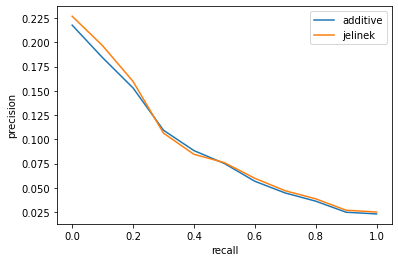

In [10]:
# TODO: compare these two types of smoothing with evaluation metrics you've just impemented. Follow the output format given. 

